In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
from scipy import interpolate

In [2]:
path = "/Users/atalianb/Documents/data_LBSG/Blok_McGaugh_& _Rubin_(2001)/"

In [3]:
ESO3020120 = np.loadtxt(path+'ESO3020120.dat')

In [4]:
vecRp_ESO3020120 = np.array([row[1] for row in ESO3020120])# galactocentric distance [kpc]
vecvRp_ESO3020120 = np.array([row[5] for row in ESO3020120])# rotation velocity [km/s]
vecerrvRp_ESO3020120 = np.array([row[6] for row in ESO3020120])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

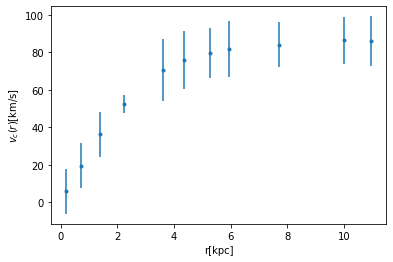

In [5]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

### Para $\ell=0$ la condición inicial $\phi_{0}$ no cambia y es $\phi_{0} = 1$, por lo que los términos a ajustar serán $\epsilon$ y $m_{a}$

In [6]:
##Values
####
eps_ = 2.5e-4#
m_a_ = 1.0e-22#eV/c^2
G_kpc = 4.302e-6#kpc/SolarMass(km/s)^2
####
##Integration values
###
x0_0 = 3.#first integration
x0_0v1 = 0.01# Start of integration. Use 0.01 for continuity in l=3 solution, for 0,1,2 0.0 it's ok
xf_0v1 = 10.# End of integration
step_0 = 0.5#Step to integrate from x0_0 until xf_0v1 is reached
##l=0
u1_0 = 0.63173215# 1st trial value of unknown init. cond.
u2_0 = 1.28125868# 2nd trial value of unknown init. cond.
u_0 = np.array([u1_0, u2_0])

In [7]:
def Integrate(func,x0,y0,x,h):
    # Finds value of y for a given x using step size h 
    # and initial value y0 at x0.
    def RK4(func,x0,y0,h):
        K0 = h*func(x0,y0)
        K1 = h*func(x0 + 0.5*h, y0 + 0.5*K0)
        K2 = h*func(x0 + 0.5*h, y0 + 0.5*K1)
        K3 = h*func(x0 + h, y0 + K2)
        return (K0 + 2.*K1 + 2.*K2 + K3)/6.
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
         # Count number of iterations using step size or
        h = min(h,x - x0)# step height h
        y0 = y0 + RK4(func,x0,y0,h)#update next value of y
        x0 = x0 + h#update next value of x
        X.append(x0)
        Y.append(y0)
    return np.array(X),np.array(Y)

In [8]:
def shooting(func,u,x0,x,xf,step,k,h=0.01):
    def res(u):# Boundary condition residual
        X,Y = Integrate(func,x0,IC(u,k),x,h)
        y = Y[len(Y) - 1]#last value of Y
        r = np.zeros(len(u))
        r[0] = y[0]#y0(inf)=0
        r[1] = y[2]/x + y[3]#y_3(inf)/r + y_4(inf)=0
        return r
    x_list = []
    root_list = []
    while x<=xf:
        x_list.append(x)
        root = optimize.root(res,u)
        u = root.x
        root_temp = optimize.root(res,root.x)
        root_list.append(root_temp.x)
        X,Y = Integrate(func,x0,IC(root_temp.x,k),x,h)
        x = x+step
    return X,Y,root_temp,np.array(x_list),np.array(root_list)

In [9]:
def IC(u,k):#Initial conditions array, the first correspond to the initial condition in phi
    return np.array([k,0.0,u[0],0.0,u[1]])

In [10]:
def f0(x,y):
    l = 0.
    F = np.zeros(5)
    if x==0:
        F[0] = y[1]
        F[1] = 2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = 0.
        F[4] = 0.
    else:
        F[0] = y[1]
        F[1] = -2.*(l+1.)*y[1]/x +2.*y[0]*(y[2]-y[4])
        F[2] = y[3]
        F[3] = (2.*l+1.)*x**(2.*l)*y[0]**2. - 2.*y[3]/x
        F[4] = 0.
    return F

In [11]:
def Mass_func(r,phi,l):
    Int = np.zeros(len(r))
    dr = np.diff(r)[0]
    phi_array = np.array(phi[:,0])
    for i in range(0,len(r)-1):
        Int[i+1] = dr*(phi_array[i+1]**2.*r[i+1]**(2.*l+2.)) + Int[i]
    return Int

In [12]:
def Vc2_cir(r,eps,M):
    units =8.95e10*eps**2.
    return (units*M)/r
####
##Units for r in kpc
###
def r_units(r,eps,m_a):
    return (6.39e-27*r)/(eps*m_a)

In [13]:
#The function integrate f0 with the shooting method,
#integrates to find the M(r) and returns the r[kpc] and Vc[km/s] 
#if the last element of r[kpc] array is minor than the last element of the r data array
#takes the last element of the M(r) array and compute the Vc^2 for the rest of the r elements
def Vc_xy(r,m_a,eps,l=0.):
    X0,Y0,root0_f,arr_x0,arr_list0=shooting(f0,u_0,x0_0v1,x0_0,xf_0v1,step_0,k=1.)
    M_r0 = Mass_func(X0,Y0,l=0.)#Integrates rho(r) to obtain M(r)
    Vc2_r0 = Vc2_cir(X0,eps,M_r0)#Vc^2[km/s]^2 theoretical
    X0_units = r_units(X0,eps,m_a)#r[kpc] theoretical
    M_r0_units = M_r0*eps*1.34e-10/m_a#M(r) with Solar Mass units
    if X0_units[-1]<r[-1]:
        #array from last element of the r[kpc] theoretical to the last element of the data array,
        # with 80 elements. It can be replaced by np.arange(X0_units[-1],vecRp_data[-1],0.1) 
        #but you have to be careful in the next function with interpolate
        r_array = np.linspace(X0_units[-1],r[-1],80)
        Vc2_rmayor = G_kpc*M_r0_units[-1]/r_array#Computes Vc^2 with with the last result from M(r)
        Vc2_total = np.append(Vc2_r0,Vc2_rmayor)#creates an array of Vc^2 with Vc2_r0 and Vc2_rmayor
        r_total = np.append(X0_units,r_array)
        return r_total,np.sqrt(Vc2_total)
    else:
        return X0_units,np.sqrt(Vc2_r0)

In [14]:
def Vc_xi2(r,m_a,eps,l=0.):
    Vc = Vc_xy(r,m_a,eps)
    #If you want to use np.arange in the previous function, It is recommended to use extrapolate
    f = interpolate.interp1d(Vc[0],Vc[1],fill_value='extrapolate')
    Vc_new = f(r)
    return Vc_new

# $\chi^{2}$

$\epsilon$

In [15]:
def Chi2_eps(parameter):
    eps = np.exp(parameter)
    model = Vc_xi2(vecRp_ESO3020120,m_a_,eps,l=0.)
    xi = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [16]:
x0_eps = np.array(np.log(1.0e-4))
LS_eps = optimize.minimize(Chi2_eps,x0_eps,method='L-BFGS-B',bounds=((np.log(1.0e-6),np.log(1.0e-3)),))
print(LS_eps)

      fun: 162.6105266685624
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([-8.15808989])


In [17]:
print(np.exp(LS_eps.x))

[0.00028641]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

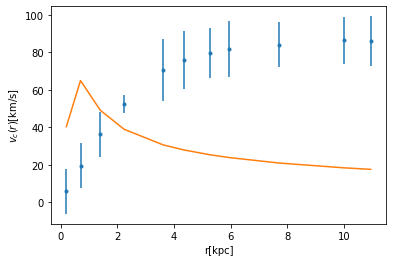

In [18]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,m_a_,np.asscalar(np.exp(LS_eps.x))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

$m_{a}$

In [19]:
def Chi2_m_a(parameter):
    m_a = np.exp(parameter)
    model = Vc_xi2(vecRp_ESO3020120,m_a,eps_,l=0.)
    xi = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [20]:
x0_m_a = np.array(np.log(1.0e-23))
LS_m_a = optimize.minimize(Chi2_m_a,x0_m_a,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),))
print(LS_m_a)

      fun: 38.770636230575924
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.42108535e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-52.69155739])


In [21]:
print(np.exp(LS_m_a.x))

[1.30721608e-23]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

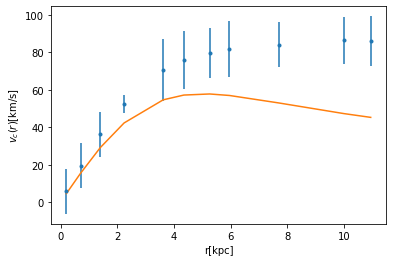

In [22]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a.x)),eps_))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Dos parámetros

$m_{a}$ y $\epsilon$

In [23]:
def Vc_l0_m_a_eps(r,params):
    m_a,eps = params
    return Vc_xi2(r,m_a,eps,l=0.)

In [24]:
def Xi2_m_a_eps(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO3020120,par)
    xi  = np.sum((vecvRp_ESO3020120-model)**2./(vecerrvRp_ESO3020120)**2.)
    return xi

In [25]:
x0_m_a_eps = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps = optimize.minimize(Xi2_m_a_eps,x0_m_a_eps,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps)

      fun: 0.9642427830916371
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.56381561e-06, 1.91180406e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([-53.42721728,  -7.86921013])


In [26]:
print(np.exp(LS_m_a_eps.x))

[6.26403757e-24 3.82336240e-04]


In [27]:
str(LS_m_a_eps.x[0])

'-53.42721727561416'

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 1.0, '$m_{a}$=6.264037568793628e-24$\\epsilon$=0.00038233623971521734')

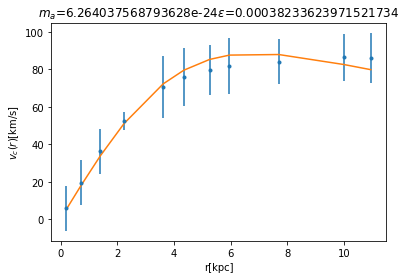

In [28]:
plt.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
plt.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")
plt.title(r'$m_{a}$='+str(np.exp(LS_m_a_eps.x[0]))+r'$\epsilon$='+str(np.exp(LS_m_a_eps.x[1])))

# Acotando las fronteras

In [29]:
np.log(1.0e-24),np.log(1.0e-22),np.log(1.0e-6),np.log(1.0e-4)

(-55.262042231857095,
 -50.65687204586901,
 -13.815510557964274,
 -9.210340371976182)

In [30]:
x0_m_a_eps = np.array([np.log(5.0e-23),np.log(1.0e-4)])
LS_m_a_eps = optimize.minimize(Xi2_m_a_eps,x0_m_a_eps,method='L-BFGS-B',bounds=((np.log(9.0e-24),np.log(1.0e-23)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps)

      fun: 6.484117566624899
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.02657528e+01, 6.21724898e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([-53.06481765,  -7.98292444])


In [31]:
print(np.exp(LS_m_a_eps.x))

[9.00000000e-24 3.41240026e-04]


# ESO3050090

In [32]:
ESO3050090 = np.loadtxt(path+'ESO3050090.dat')

In [33]:
vecRp_ESO3050090 = np.array([row[1] for row in ESO3050090])# galactocentric distance [kpc]
vecvRp_ESO3050090 = np.array([row[5] for row in ESO3050090])# rotation velocity [km/s]
vecerrvRp_ESO3050090 = np.array([row[6] for row in ESO3050090])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

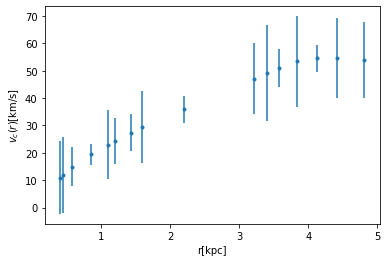

In [34]:
plt.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [35]:
def Xi2_m_a_eps_ESO3050090(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO3050090,par)
    xi  = np.sum((vecvRp_ESO3050090-model)**2./(vecerrvRp_ESO3050090)**2.)
    return xi

In [36]:
x0_m_a_eps_ESO3050090 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_ESO3050090 = optimize.minimize(Xi2_m_a_eps_ESO3050090,x0_m_a_eps_ESO3050090,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-20)),(np.log(1.0e-5),np.log(1.)),))
print(LS_m_a_eps_ESO3050090)

      fun: 0.9845829924193381
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.87227995e-06, -1.19459988e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 9
     njev: 15
   status: 0
  success: True
        x: array([-52.67108829,  -8.34479207])


In [37]:
print(np.exp(LS_m_a_eps_ESO3050090.x))

[1.33424935e-23 2.37630866e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

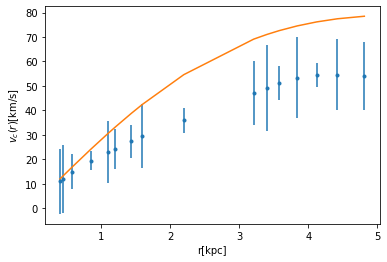

In [38]:
plt.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
plt.plot(vecRp_ESO3050090,Vc_xi2(vecRp_ESO3050090,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Acotando las fronteras

In [39]:
np.log(5.0e-23),np.log(5.0e-22),np.log(1.0e-23)

(-51.35001922642895, -49.047434133434905, -52.95945713886305)

In [40]:
x0_m_a_eps_ESO3050090 = np.array([np.log(1.0e-23),np.log(5.0e-5)])
LS_m_a_eps_ESO3050090 = optimize.minimize(Xi2_m_a_eps_ESO3050090,x0_m_a_eps_ESO3050090,method='TNC',bounds=((np.log(1.0e-23),np.log(5.0e-22)),(np.log(4.0e-5),np.log(7.0e-5)),))
print(LS_m_a_eps_ESO3050090)

     fun: 153.2929158930711
     jac: array([ 4.78706812e-02, -1.53012273e+02])
 message: 'Linear search failed'
    nfev: 183
     nit: 6
  status: 4
 success: False
       x: array([-50.82355548,  -9.56701532])


In [41]:
print(np.exp(LS_m_a_eps_ESO3050090.x))

[8.46467528e-23 7.00000000e-05]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

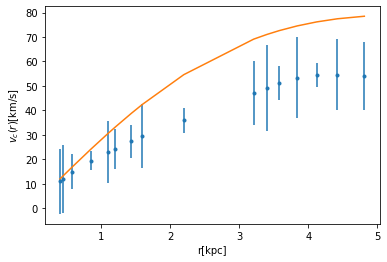

In [42]:
plt.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
plt.plot(vecRp_ESO3050090,Vc_xi2(vecRp_ESO3050090,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Grid 

In [43]:
ma_array = np.linspace(np.log(1.0e-24),np.log(1.0e-20),15)
eps_array = np.linspace(np.log(1.0e-5),np.log(1.0e-3),15)

In [48]:
Z = np.zeros((len(ma_array), len(eps_array)))
for i in range(0,len(ma_array)):
    for j in range(0,len(eps_array)):
        parameters = np.array([ma_array[i],eps_array[j]])
        Z[j,i] = Xi2_m_a_eps_ESO3050090(parameters)

In [49]:
Ma_grid,Eps_grid = np.meshgrid(ma_array,eps_array)

Text(0.5, 0, '$\\chi$')

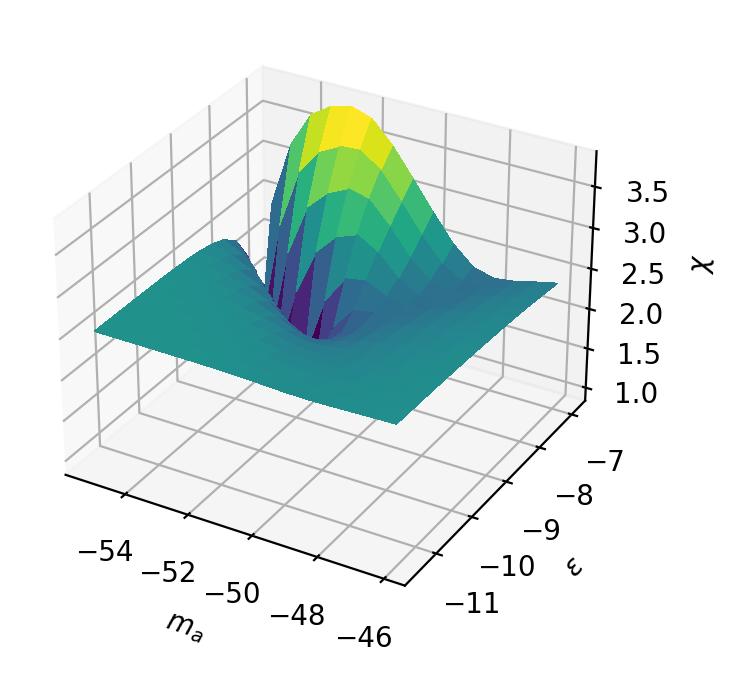

In [50]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=200)
# Plot the surface.
surf = ax.plot_surface(Ma_grid,Eps_grid,np.log10(Z),cmap='viridis',linewidth=0,antialiased=False)
ax.set_xlabel(r'$m_{a}$')
ax.set_ylabel(r'$\epsilon$')
ax.set_zlabel(r'$\chi$')

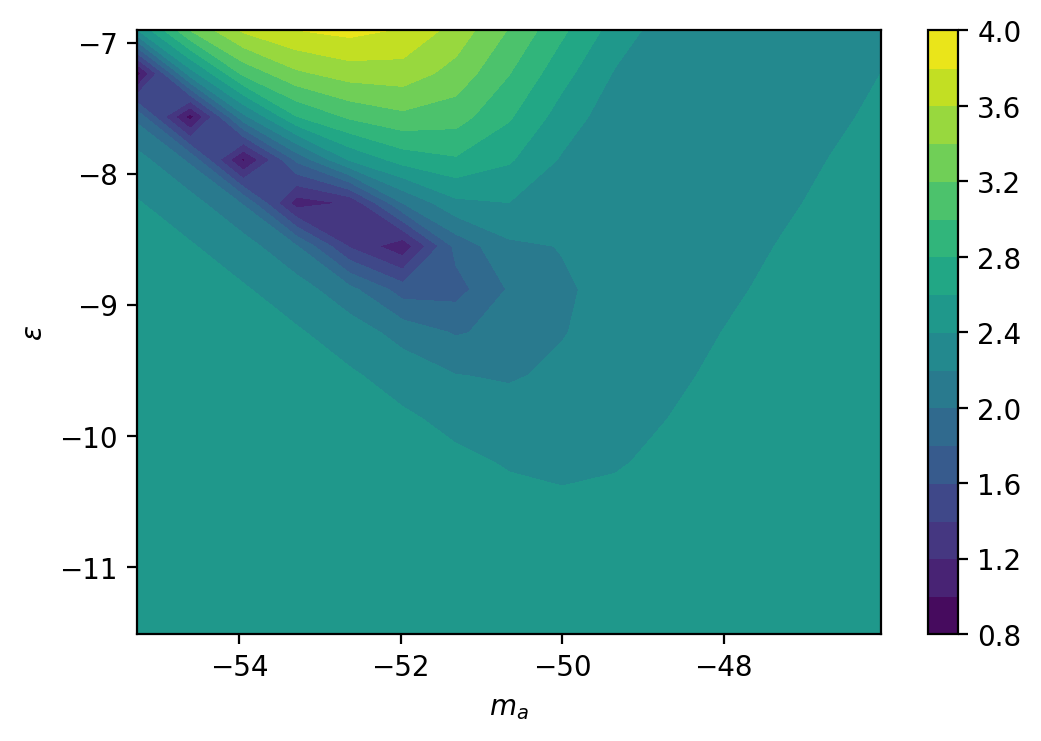

In [51]:
fig = plt.figure(dpi=200)
plt.contourf(Ma_grid,Eps_grid,np.log10(Z),15,cmap='viridis')
plt.xlabel(r'$m_{a}$')
plt.ylabel(r'$\epsilon$')
plt.colorbar();

In [52]:
#m_a
np.exp(-55),np.exp(-53),np.exp(-54)

(1.2995814250075031e-24, 9.602680054508676e-24, 3.532628572200807e-24)

In [53]:
#epsilon
np.exp(-8.),np.exp(-8.5),np.exp(-8),np.log(3.0e-4)

(0.00033546262790251185,
 0.00020346836901064417,
 0.00033546262790251185,
 -8.111728083308073)

In [54]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

(0.8943670607380054, 3.861197985992135)

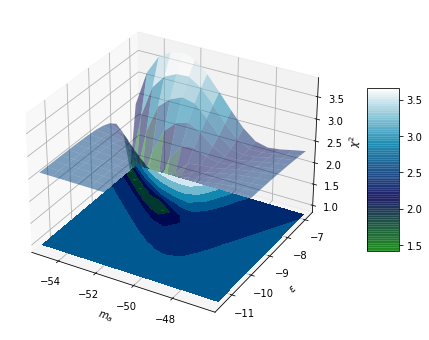

In [55]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
#####
surf = ax.plot_surface(Ma_grid,Eps_grid,np.log10(Z), rstride=1, cstride=1, alpha=0.5, cmap=cm.ocean)
cset = ax.contourf(Ma_grid,Eps_grid,np.log10(Z), zdir='z', offset=np.min(np.log10(Z)), cmap=cm.ocean)
cset = ax.contourf(Ma_grid,Eps_grid,np.log10(Z), zdir='x', offset=-5, cmap=cm.ocean)
cset = ax.contourf(Ma_grid,Eps_grid,np.log10(Z), zdir='y', offset=5, cmap=cm.ocean)
#####
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
####
ax.set_xlabel(r'$m_{a}$')
ax.set_xlim(np.min(Ma_grid),np.max(Ma_grid))
ax.set_ylabel(r'$\epsilon$')
ax.set_zlim(np.min(Eps_grid),np.max(Eps_grid))
ax.set_zlabel(r'$\chi^{2}$')
ax.set_zlim(np.min(np.log10(Z)), np.max(np.log10(Z)))

# Volviendo a minimizar

In [66]:
np.log(9.0e-24),np.log(1.0e-23),np.log(9.0e-23)

(-53.06481765452088, -52.95945713886305, -50.76223256152683)

In [69]:
x0_m_a_eps_ESO3050090 = np.array([np.log(1.0e-23),np.log(2.5e-4)])
LS_m_a_eps_ESO3050090 = optimize.minimize(Xi2_m_a_eps_ESO3050090,x0_m_a_eps_ESO3050090,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(5.0e-23)),(np.log(2.0e-4),np.log(3.0e-4)),))
print(LS_m_a_eps_ESO3050090)

      fun: 0.9845829924297165
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.36903810e-05, -1.68165468e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([-52.67108803,  -8.34479226])


In [70]:
print(np.exp(LS_m_a_eps_ESO3050090.x))

[1.33424970e-23 2.37630821e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

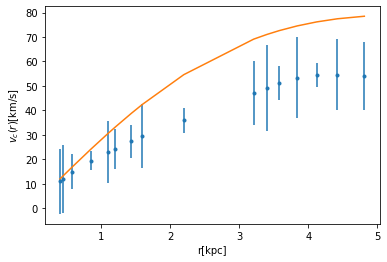

In [71]:
plt.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
plt.plot(vecRp_ESO3050090,Vc_xi2(vecRp_ESO3050090,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# ESO4880049

In [72]:
ESO4880049 = np.loadtxt(path+'ESO4880049.dat')

In [73]:
vecRp_ESO4880049 = np.array([row[1] for row in ESO4880049])# galactocentric distance [kpc]
vecvRp_ESO4880049 = np.array([row[5] for row in ESO4880049])# rotation velocity [km/s]
vecerrvRp_ESO4880049 = np.array([row[6] for row in ESO4880049])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

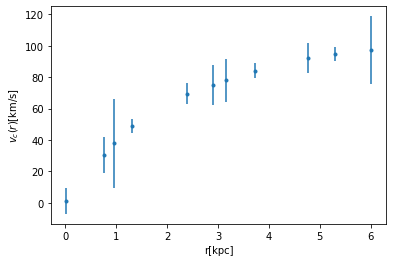

In [74]:
plt.errorbar(vecRp_ESO4880049,vecvRp_ESO4880049,yerr=vecerrvRp_ESO4880049,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [75]:
def Xi2_m_a_eps_ESO4880049(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_ESO4880049,par)
    xi  = np.sum((vecvRp_ESO4880049-model)**2./(vecerrvRp_ESO4880049)**2.)
    return xi

In [76]:
x0_m_a_eps_ESO4880049 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_ESO4880049 = optimize.minimize(Xi2_m_a_eps_ESO4880049,x0_m_a_eps_ESO4880049,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_ESO4880049)

      fun: 2.7953381896133043
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.04121148e-06, 1.90070183e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 14
     njev: 20
   status: 0
  success: True
        x: array([-53.16147831,  -7.82461201])


In [77]:
print(np.exp(LS_m_a_eps_ESO4880049.x))

[8.17077628e-24 3.99773665e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

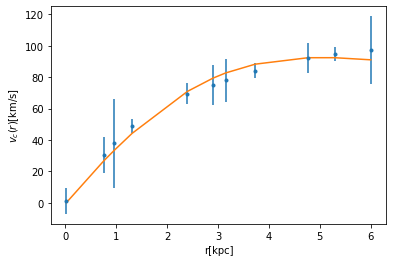

In [78]:
plt.errorbar(vecRp_ESO4880049,vecvRp_ESO4880049,yerr=vecerrvRp_ESO4880049,fmt='.')
plt.plot(vecRp_ESO4880049,Vc_xi2(vecRp_ESO4880049,np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

In [79]:
ma_array_ESO4880049 = np.linspace(np.log(1.0e-24),np.log(1.0e-22),15)
eps_array_ESO4880049 = np.linspace(np.log(1.0e-5),np.log(1.0e-3),15)

In [80]:
Z_ESO4880049 = np.zeros((len(ma_array_ESO4880049), len(eps_array_ESO4880049)))
for i in range(0,len(ma_array_ESO4880049)):
    for j in range(0,len(eps_array_ESO4880049)):
        parameters = np.array([ma_array_ESO4880049[i],eps_array_ESO4880049[j]])
        Z_ESO4880049[j,i] = Xi2_m_a_eps_ESO4880049(parameters)

In [81]:
Ma_grid_ESO4880049,Eps_grid_ESO4880049 = np.meshgrid(ma_array_ESO4880049,eps_array_ESO4880049)

Text(0.5, 0, '$\\chi$')

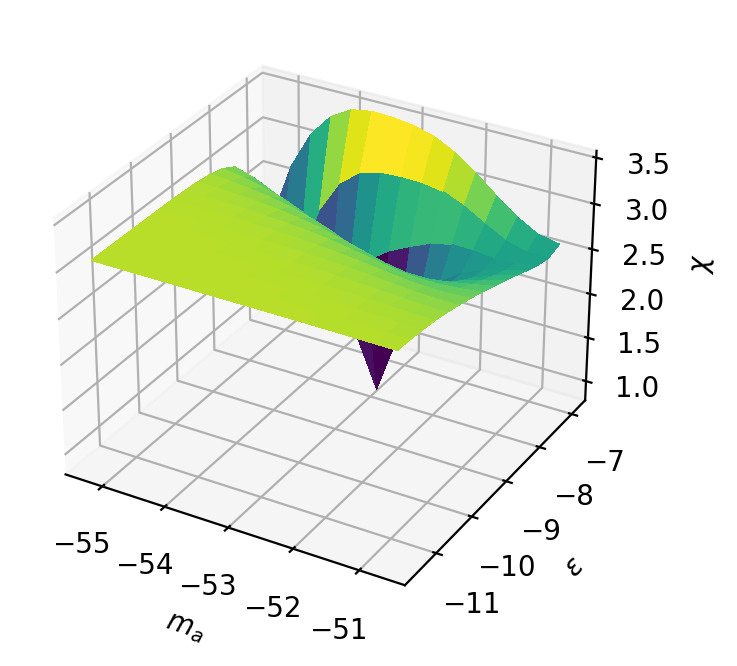

In [82]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},dpi=200)
# Plot the surface.
surf = ax.plot_surface(Ma_grid_ESO4880049,Eps_grid_ESO4880049,np.log10(Z_ESO4880049),cmap='viridis',linewidth=0,antialiased=False)
ax.set_xlabel(r'$m_{a}$')
ax.set_ylabel(r'$\epsilon$')
ax.set_zlabel(r'$\chi$')

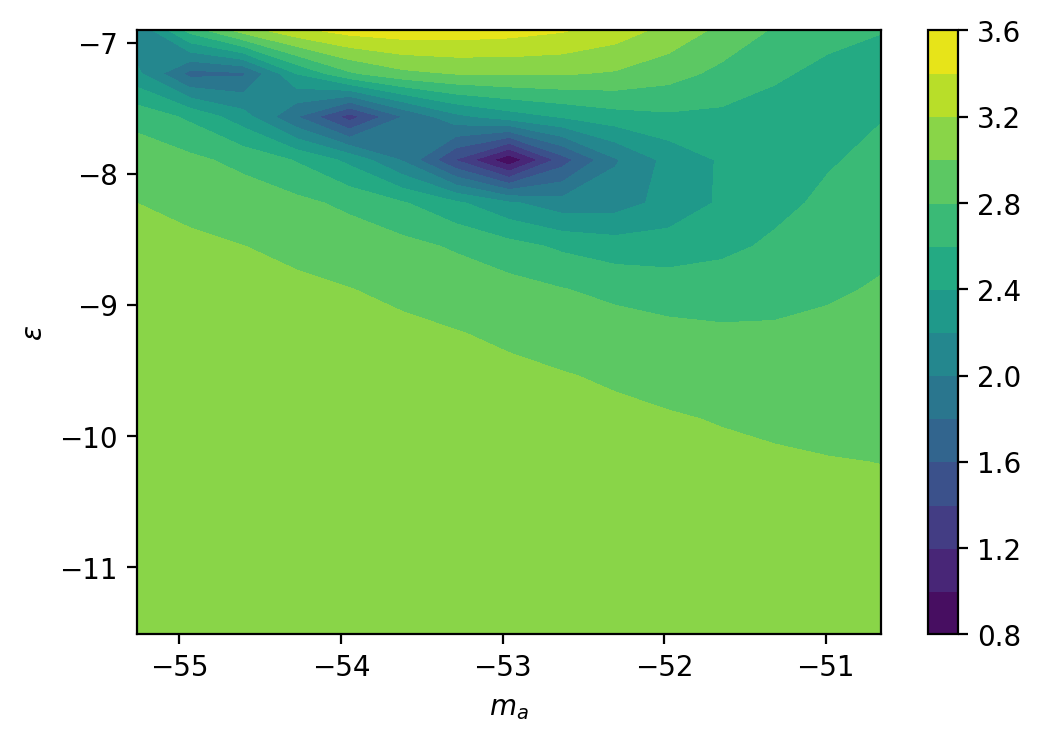

In [83]:
fig = plt.figure(dpi=200)
plt.contourf(Ma_grid_ESO4880049,Eps_grid_ESO4880049,np.log10(Z_ESO4880049),15,cmap='viridis')
plt.xlabel(r'$m_{a}$')
plt.ylabel(r'$\epsilon$')
plt.colorbar();

# U11557

In [84]:
U11557 = np.loadtxt(path+'U11557.dat')

In [85]:
vecRp_U11557 = np.array([row[1] for row in U11557])# galactocentric distance [kpc]
vecvRp_U11557 = np.array([row[5] for row in U11557])# rotation velocity [km/s]
vecerrvRp_U11557 = np.array([row[6] for row in U11557])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

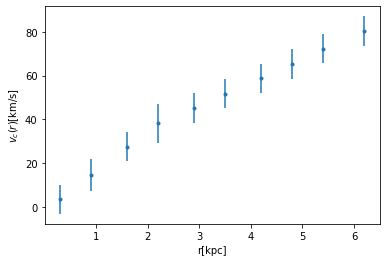

In [86]:
plt.errorbar(vecRp_U11557,vecvRp_U11557,yerr=vecerrvRp_U11557,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [87]:
def Xi2_m_a_eps_U11557(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_U11557,par)
    xi  = np.sum((vecvRp_U11557-model)**2./(vecerrvRp_U11557)**2.)
    return xi

In [88]:
x0_m_a_eps_U11557 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_U11557 = optimize.minimize(Xi2_m_a_eps_U11557,x0_m_a_eps_U11557,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_U11557)

      fun: 0.5189083682660515
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.22124523e-05, -2.54463119e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 14
     njev: 27
   status: 0
  success: True
        x: array([-54.0013837 ,  -7.80023413])


In [89]:
print(np.exp(LS_m_a_eps_U11557.x))

[3.52774385e-24 4.09639060e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

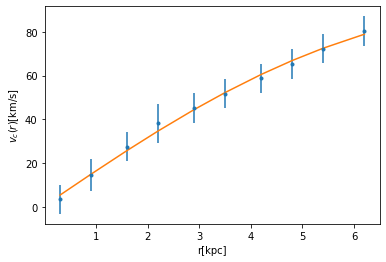

In [90]:
plt.errorbar(vecRp_U11557,vecvRp_U11557,yerr=vecerrvRp_U11557,fmt='.')
plt.plot(vecRp_U11557,Vc_xi2(vecRp_U11557,np.asscalar(np.exp(LS_m_a_eps_U11557.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11557.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# U11616

In [91]:
U11616 = np.loadtxt(path+'U11616.dat')

In [92]:
vecRp_U11616 = np.array([row[1] for row in U11616])# galactocentric distance [kpc]
vecvRp_U11616 = np.array([row[5] for row in U11616])# rotation velocity [km/s]
vecerrvRp_U11616 = np.array([row[6] for row in U11616])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

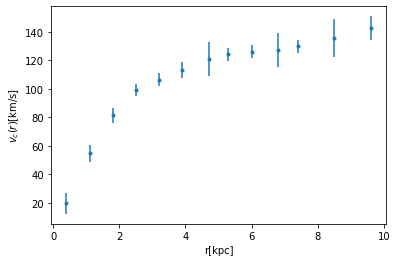

In [93]:
plt.errorbar(vecRp_U11616,vecvRp_U11616,yerr=vecerrvRp_U11616,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [94]:
def Xi2_m_a_eps_U11616(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_U11616,par)
    xi  = np.sum((vecvRp_U11616-model)**2./(vecerrvRp_U11616)**2.)
    return xi

In [95]:
x0_m_a_eps_U11616 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_U11616 = optimize.minimize(Xi2_m_a_eps_U11616,x0_m_a_eps_U11616,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_U11616)

      fun: 23.436064819258704
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.71462830e-05, -4.17799131e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 11
     njev: 18
   status: 0
  success: True
        x: array([-53.66220102,  -7.47326793])


In [96]:
print(np.exp(LS_m_a_eps_U11616.x))

[4.95224602e-24 5.68068849e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

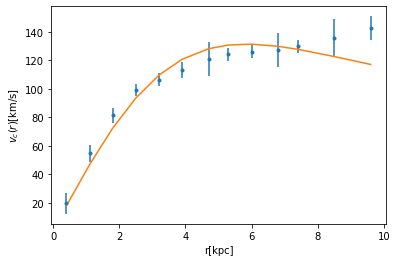

In [97]:
plt.errorbar(vecRp_U11616,vecvRp_U11616,yerr=vecerrvRp_U11616,fmt='.')
plt.plot(vecRp_U11616,Vc_xi2(vecRp_U11616,np.asscalar(np.exp(LS_m_a_eps_U11616.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11616.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# U4115

In [98]:
U4115 = np.loadtxt(path+'U4115.dat')

In [99]:
vecRp_U4115 = np.array([row[1] for row in U4115])# galactocentric distance [kpc]
vecvRp_U4115 = np.array([row[5] for row in U4115])# rotation velocity [km/s]
vecerrvRp_U4115 = np.array([row[6] for row in U4115])# error in rotation velocity [km/s]

Text(0.5, 0, 'r[kpc]')

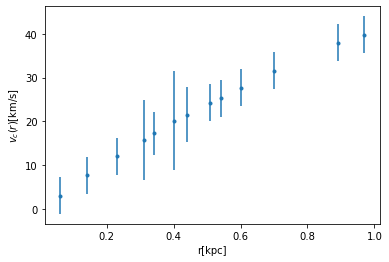

In [100]:
plt.errorbar(vecRp_U4115,vecvRp_U4115,yerr=vecerrvRp_U4115,fmt='.')
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# $\chi^{2}$

$m_{a}$ y $\epsilon$

In [101]:
def Xi2_m_a_eps_U4115(params):
    m_a,eps = params
    par = np.exp(m_a),np.exp(eps)
    model = Vc_l0_m_a_eps(vecRp_U4115,par)
    xi  = np.sum((vecvRp_U4115-model)**2./(vecerrvRp_U4115)**2.)
    return xi

In [102]:
x0_m_a_eps_U4115 = np.array([np.log(1.0e-23),np.log(1.0e-4)])
LS_m_a_eps_U4115 = optimize.minimize(Xi2_m_a_eps_U4115,x0_m_a_eps_U4115,method='L-BFGS-B',bounds=((np.log(1.0e-24),np.log(1.0e-22)),(np.log(1.0e-5),np.log(1.0e-3)),))
print(LS_m_a_eps_U4115)

      fun: 0.043638090941080135
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.08166800e-09, 9.71445066e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 16
     njev: 24
   status: 0
  success: True
        x: array([-51.56626599,  -8.44496809])


In [103]:
print(np.exp(LS_m_a_eps_U4115.x))

[4.02768250e-23 2.14979455e-04]


/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  


Text(0.5, 0, 'r[kpc]')

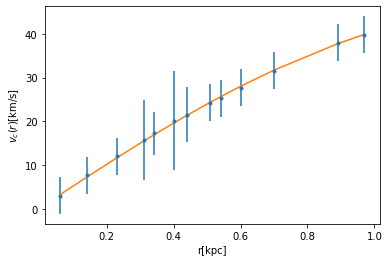

In [104]:
plt.errorbar(vecRp_U4115,vecvRp_U4115,yerr=vecerrvRp_U4115,fmt='.')
plt.plot(vecRp_U4115,Vc_xi2(vecRp_U4115,np.asscalar(np.exp(LS_m_a_eps_U4115.x[0])),np.asscalar(np.exp(LS_m_a_eps_U4115.x[1]))))
plt.ylabel(r'$v_{c}(r)$[km/s]')
plt.xlabel("r[kpc]")

# Subplots

/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if sys.path[0] == '':
/Users/atalianb/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since

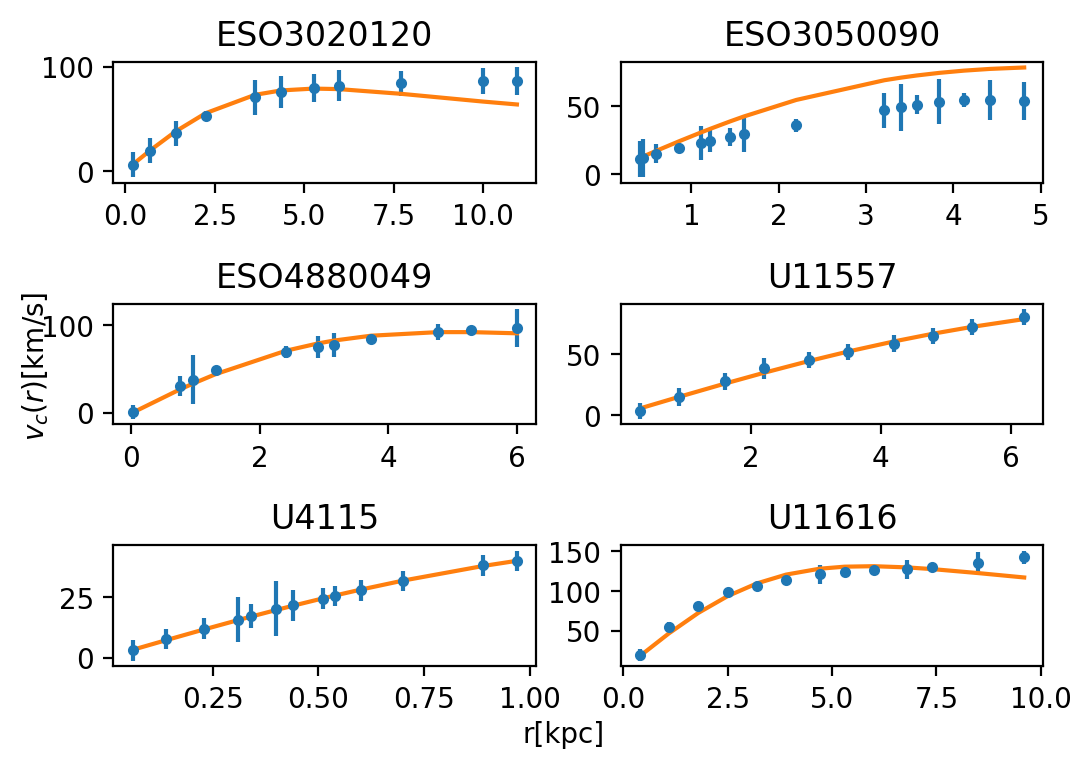

In [105]:
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=3,ncols=2,dpi=200)
ax0.errorbar(vecRp_ESO3020120,vecvRp_ESO3020120,yerr=vecerrvRp_ESO3020120,fmt='.')
ax0.plot(vecRp_ESO3020120,Vc_xi2(vecRp_ESO3020120,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
ax0.set_title('ESO3020120')
ax1.errorbar(vecRp_ESO3050090,vecvRp_ESO3050090,yerr=vecerrvRp_ESO3050090,fmt='.')
ax1.plot(vecRp_ESO3050090,Vc_xi2(vecRp_ESO3050090,np.asscalar(np.exp(LS_m_a_eps.x[0])),np.asscalar(np.exp(LS_m_a_eps.x[1]))))
ax1.set_title('ESO3050090')
ax2.errorbar(vecRp_ESO4880049,vecvRp_ESO4880049,yerr=vecerrvRp_ESO4880049,fmt='.')
ax2.plot(vecRp_ESO4880049,Vc_xi2(vecRp_ESO4880049,np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[0])),np.asscalar(np.exp(LS_m_a_eps_ESO4880049.x[1]))))
ax2.set_title('ESO4880049')
ax3.errorbar(vecRp_U11557,vecvRp_U11557,yerr=vecerrvRp_U11557,fmt='.')
ax3.plot(vecRp_U11557,Vc_xi2(vecRp_U11557,np.asscalar(np.exp(LS_m_a_eps_U11557.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11557.x[1]))))
ax3.set_title('U11557')
ax4.errorbar(vecRp_U4115,vecvRp_U4115,yerr=vecerrvRp_U4115,fmt='.')
ax4.plot(vecRp_U4115,Vc_xi2(vecRp_U4115,np.asscalar(np.exp(LS_m_a_eps_U4115.x[0])),np.asscalar(np.exp(LS_m_a_eps_U4115.x[1]))))
ax4.set_title('U4115')
ax5.errorbar(vecRp_U11616,vecvRp_U11616,yerr=vecerrvRp_U11616,fmt='.')
ax5.plot(vecRp_U11616,Vc_xi2(vecRp_U11616,np.asscalar(np.exp(LS_m_a_eps_U11616.x[0])),np.asscalar(np.exp(LS_m_a_eps_U11616.x[1]))))
ax5.set_title('U11616')
# Set common labels
fig.text(0.5, 0.04, 'r[kpc]', ha='center', va='center')
fig.text(0.06, 0.5, r'$v_{c}(r)$[km/s]', ha='center', va='center', rotation='vertical')
plt.subplots_adjust(hspace=1.)